### Volatility Smile and Term Structure of Bitcoin

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import requests
import yfinance as yf
from sklearn.neighbors import KNeighborsRegressor

# Use this function below if you want to get updated option data
sys.path.append("..")
import deribit_data as dm

### 1. Download and Filter Data

#### Load and Filter Bitcoin Call Options Data

In [8]:
# Run this command below to download the most recent data
'''
btc_data = dm.Options("BTC")
btc_data.collect_data(save_csv=True)
'''

# Pre-loading downloaded data
btc_df = pd.read_csv("options_data.csv", index_col=0)
btc_df['mid_iv'] = (btc_df.bid_iv + btc_df.ask_iv)/2

# We want to select the last value to get the December 2020 Call
expiries = list(set(btc_df.expiration_timestamp))
expiries.sort()
date = expiries[-1]

In [9]:
# Confirm correct date
pd.to_datetime(date, unit='ms')

Timestamp('2020-12-25 08:00:00')

In [10]:
# Only extract the call options for Dec. 25, 2020 expiry
btc_call = btc_df[btc_df.option_type == 'call']
btc_subset = btc_call[btc_call.expiration_timestamp == date].sort_values('strike')
btc_subset[['strike', 'mid_iv',]].head()

,strike,mid_iv
117,3000.0,107.045
29,4000.0,101.295
48,5000.0,98.415
288,6000.0,92.555
80,7000.0,91.085


### 2. Simple KNN Regression
This will be useful to help emphasis the "smile" in the plot.

In [11]:
# BTC Implied Volatility KNN Fit
btc_knn = KNeighborsRegressor(n_neighbors=2)

btc_knn.fit(btc_subset.strike.values.reshape(-1,1), 
            btc_subset.mid_iv.values.reshape(-1,1))

btc_smoothed_fit = btc_knn.predict(btc_subset.strike.values.reshape(-1,1))

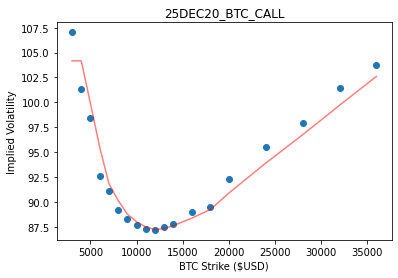

In [12]:
plt.plot(btc_subset.strike, btc_smoothed_fit, c='r', alpha=0.50, label='KNN Fit')
plt.scatter(btc_subset.strike, btc_subset.mid_iv, label='Mid Implied Volatility')
plt.title("25DEC20_BTC_CALL")
plt.xlabel("BTC Strike ($USD)")
plt.ylabel("Implied Volatility");

### 3. Analyze Term Structure of ATM Options

Inspired from skew.com's excellent data analytics. https://analytics.skew.com/dashboard/bitcoin-options

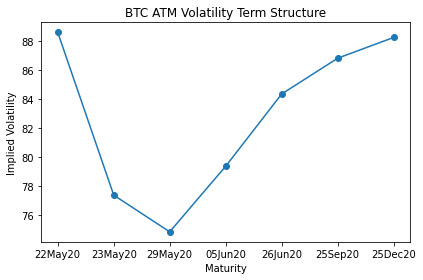

In [7]:
# Consider all calls and puts near current ATM price of $9000
atm_options = btc_df[(btc_df.strike == 9000)]
vol_structure = atm_options.groupby("expiration_timestamp").mean()

plt.plot(pd.to_datetime(vol_structure.index, unit='ms').strftime('%d%b%y'), 
            vol_structure.mid_iv, marker='o')
plt.title("BTC ATM Volatility Term Structure")
plt.xlabel("Maturity")
plt.xticks(rotation=0)
plt.ylabel("Implied Volatility")
plt.tight_layout();